# Callin Switzer
### 6 Nov 2018
___
### - Evaulate weights in network
### - See if some can be set to =0
### -  Use X-validation to find ideal network size


___

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import csv
import seaborn as sns
import scipy.io
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2018-11-09 10:52:09.847337


# Make training and test set

In [5]:
# load dataset
trainDF2 = pd.read_csv(os.path.join(dataOutput, "smallDF.csv"))
trainDF2.head()

,simNum,timestep,F,alpha,phi_0,phi_99,phi_dot_0,phi_dot_99,tau,theta_0,...,x_0,x_99,x_dot_0,x_dot_99,y_0,y_99,y_dot_0,y_dot_99,Fx,Fy
0,0,0,38304.433962,5.340270,3.926991,3.869604,0.000000,-5.674295,10963.268558,0.785398,...,0.000000,6.853314,0.000100,683.734561,0.000000,-1.298536,0.000100,-133.752363,22501.211072,-30998.792903
1,0,1,34264.536249,2.465501,3.948428,4.019544,2.009397,5.425513,72580.767201,0.768478,...,-0.019322,-6.079672,-0.145396,-606.129200,2.520087,6.366770,250.908304,120.273149,-26727.166452,21441.012519
2,0,2,12045.791872,4.573819,3.966608,3.933017,-0.124272,-2.775517,93435.855346,0.768515,...,0.509507,2.986736,52.490438,193.914740,4.834518,2.470847,-18.848146,-211.050011,-1663.845687,-11930.327714
3,0,3,35562.854879,0.767089,4.000007,4.111777,3.434103,7.246049,-96088.338473,0.773977,...,-0.836633,-4.334782,-187.046694,-157.064454,6.838940,17.508792,218.755312,844.589134,25602.909376,24682.132781
4,0,4,20856.636628,2.424378,4.009324,3.995061,-2.309667,0.686804,-27142.805375,0.815904,...,0.429770,2.895126,313.730247,-65.350386,8.392823,6.771320,-58.222983,-102.458917,-15718.389244,13708.812166


In [6]:
# make dataset
X = trainDF2.loc[:, ["x_0", "y_0", "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF2.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [10]:
X.head()

,x_0,y_0,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.000000,0.000000,3.926991,0.785398,6.853314,-1.298536,3.869604,0.746382,0.000100,0.000100,0.000000,0.000000
1,-0.019322,2.520087,3.948428,0.768478,-6.079672,6.366770,4.019544,0.940422,-0.145396,250.908304,2.009397,0.087406
2,0.509507,4.834518,3.966608,0.768515,2.986736,2.470847,3.933017,0.868402,52.490438,-18.848146,-0.124272,-1.029996
3,-0.836633,6.838940,4.000007,0.773977,-4.334782,17.508792,4.111777,0.747358,-187.046694,218.755312,3.434103,2.037211
4,0.429770,8.392823,4.009324,0.815904,2.895126,6.771320,3.995061,0.761962,313.730247,-58.222983,-2.309667,-0.673328


In [11]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,22501.211072,-30998.792903,10963.268558,683.734561,-133.752363,-5.674295,-4.770986
1,-26727.166452,21441.012519,72580.767201,-606.129200,120.273149,5.425513,10.479995
2,-1663.845687,-11930.327714,93435.855346,193.914740,-211.050011,-2.775517,3.897680
3,25602.909376,24682.132781,-96088.338473,-157.064454,844.589134,7.246049,0.318982
4,-15718.389244,13708.812166,-27142.805375,-65.350386,-102.458917,0.686804,-1.304712


In [12]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [13]:
# scale data 
scalerX = StandardScaler()  
scalerY = StandardScaler()  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

# Keras models

In [8]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K
from keras.wrappers.scikit_learn import KerasRegressor

In [125]:
Xtrain_scaled_small = Xtrain_scaled[0:80000, :]
Ytrain_scaled_small = Ytrain_scaled[0:80000, :]

In [126]:
K.clear_session()


# Small model 
inputs = Input(shape=(Xtrain_scaled_small.shape[1],))

x = Dense(400, activation='tanh', kernel_regularizer=regularizers.l1(0.0001))(inputs)
# x = Dropout(.3)(x)

x = Dense(400, activation='tanh',kernel_regularizer=regularizers.l1(0.0001))(x)
# x = Dropout(.3)(x)

x = Dense(400, activation='tanh', kernel_regularizer=regularizers.l1(0.0001))(x)
x = Dropout(.3)(x)
# x = BatchNormalization()(x)

x = Dense(16, activation='tanh',kernel_regularizer=regularizers.l1(0.0001))(x)
# x = Dropout(.3)(x)

predictions = Dense(Ytrain_scaled_small.shape[1], activation='linear')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss="mse", optimizer="adam", metrics = ['mse'])
# model.set_weights(originalWeights)

In [127]:
earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=50, 
                          verbose=1, mode='auto', min_delta = 0.001)

history = model.fit(Xtrain_scaled_small, Ytrain_scaled_small, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 5000, 
                    callbacks = [earlystop])

Train on 56000 samples, validate on 24000 samples
Epoch 1/5000
 - 0s - loss: 2.1677 - mean_squared_error: 0.7131 - val_loss: 1.7779 - val_mean_squared_error: 0.3272
Epoch 2/5000
 - 0s - loss: 1.7562 - mean_squared_error: 0.3080 - val_loss: 1.6255 - val_mean_squared_error: 0.1835
Epoch 3/5000
 - 0s - loss: 1.6166 - mean_squared_error: 0.1779 - val_loss: 1.5480 - val_mean_squared_error: 0.1173
Epoch 4/5000
 - 0s - loss: 1.5565 - mean_squared_error: 0.1301 - val_loss: 1.5291 - val_mean_squared_error: 0.1130
Epoch 5/5000
 - 0s - loss: 1.5411 - mean_squared_error: 0.1303 - val_loss: 1.5132 - val_mean_squared_error: 0.1150
Epoch 6/5000
 - 0s - loss: 1.5146 - mean_squared_error: 0.1225 - val_loss: 1.4784 - val_mean_squared_error: 0.1007
Epoch 7/5000
 - 0s - loss: 1.4784 - mean_squared_error: 0.1075 - val_loss: 1.4438 - val_mean_squared_error: 0.0885
Epoch 8/5000
 - 0s - loss: 1.4452 - mean_squared_error: 0.0972 - val_loss: 1.4132 - val_mean_squared_error: 0.0817
Epoch 9/5000
 - 0s - loss: 1.4

In [128]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

332535

In [129]:
# set very small weights to 0
for ii in np.arange(2, 7):
    wts[ii][abs(wts[ii]) < 0.0005] = 0

model.set_weights(wts)

nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

12215

In [130]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()

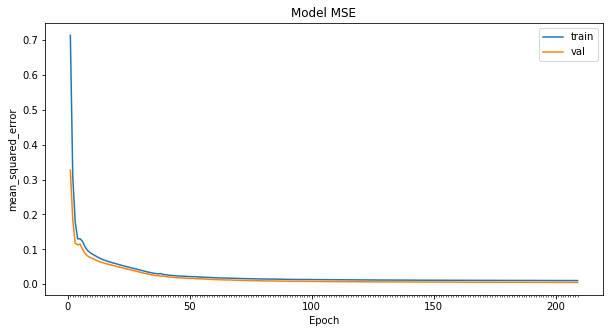

In [131]:
plot_model_history(history, saveFig = False)

In [132]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled_small.shape[0])
ValLoss = model.evaluate(Xtrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :], Ytrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :])
print(ValLoss)

24000/24000 [==============================] - 1s 31us/step
[0.05175625781714916, 0.005234345320612192]


In [214]:
model.metrics_names 

['loss', 'mean_squared_error']

In [215]:
valLoss = model.evaluate(Xtrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :], 
                           Ytrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])
print(valLoss) ## I'm not sure what the first thing is....

2400/2400 [==============================] - 0s 34us/step
[0.07284220188856125, 0.0076073716518779595]


In [218]:
pp = model.predict(Xtrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])
mean_squared_error(pp, Ytrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])

0.007607371556929382

In [57]:
# Get weights
wts = model.get_weights().copy()

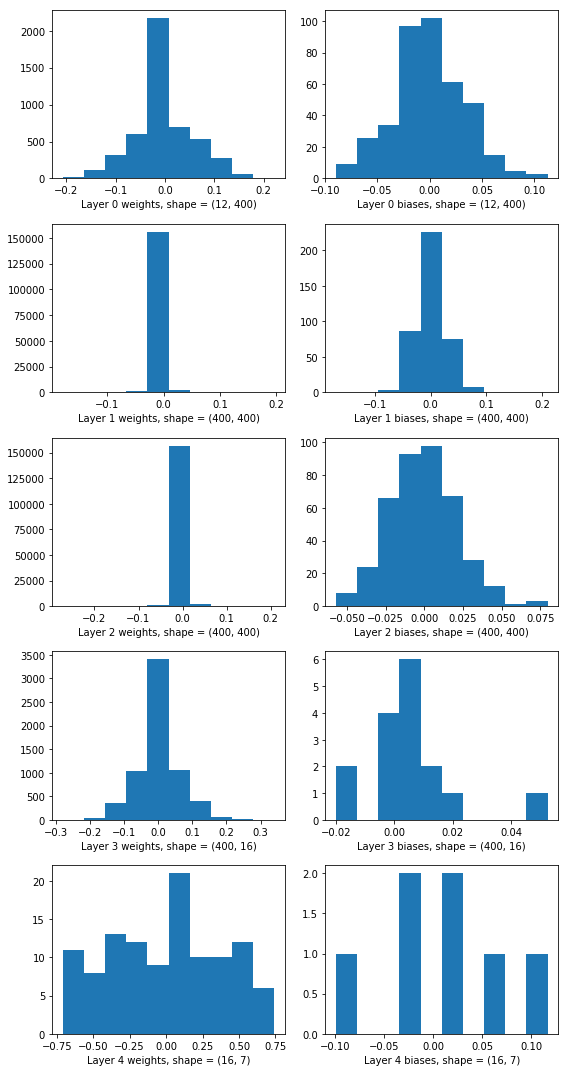

In [58]:
# show weights
plt.close("all")
fig, axs = plt.subplots(5,2, figsize=np.array((8, 15)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1))
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1])
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj].shape))
plt.tight_layout()
# plt.savefig(os.path.join(figDir, "HistogramsOfWeights.png"), dpi = 200)
plt.show()

In [32]:
wts= model.get_weights()
len(wts)

10

In [33]:
wts[1].shape

(400,)

In [34]:
model.layers

In [35]:
first_layer_weights = model.layers[1].get_weights()[0]
first_layer_biases  = model.layers[1].get_weights()[1]
first_layer_weights.shape

(12, 400)

In [36]:
model.layers[0].get_config()


{'batch_input_shape': (None, 12),
 'dtype': 'float32',
 'name': 'input_1',
 'sparse': False}

In [305]:
wts[3].shape

(400,)

(400, 400)


73

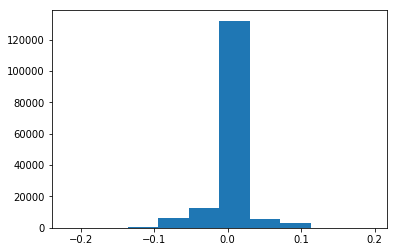

In [283]:
# modify weights
print(wts[2].shape)
wts[2][abs(wts[2]) <= 0.01] = 0
plt.hist(wts[2].reshape(-1))
np.count_nonzero(wts[3])

In [286]:
# set model weights
model.set_weights(wts)


# evaluate loss
valLoss = model.evaluate(Xtrain_scaled_small[-int(0.3*Xtrain_scaled_small.shape[0]):, :], 
                           Ytrain_scaled_small[-int(0.3*Ytrain_scaled_small.shape[0]):, :])
print(valLoss)

2400/2400 [==============================] - 0s 35us/step
[0.14641325175762177, 0.14641325175762177]


(array([  1.,   1.,   0.,  17.,  53., 218.,  80.,  26.,   3.,   1.]),
 array([-0.04144997, -0.03409896, -0.02674795, -0.01939695, -0.01204594,
        -0.00469493,  0.00265608,  0.01000708,  0.01735809,  0.0247091 ,
         0.03206011]),
 <a list of 10 Patch objects>)

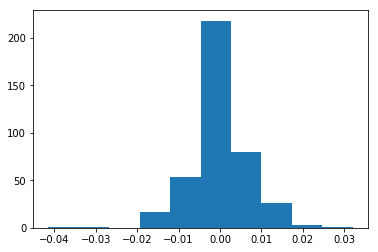

In [287]:
plt.hist(np.reshape(wts[1], -1))

In [112]:
# load model
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [113]:
model.layers

In [114]:
wts= model.get_weights()
len(wts)

10

In [73]:
wts[0].shape

(12, 400)

In [74]:
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

332535

In [75]:
model.evaluate(Xtest_scaled, Ytest_scaled)

2000000/2000000 [==============================] - 59s 29us/step


[5.4791603129910074e-05, 5.4791603129910074e-05]

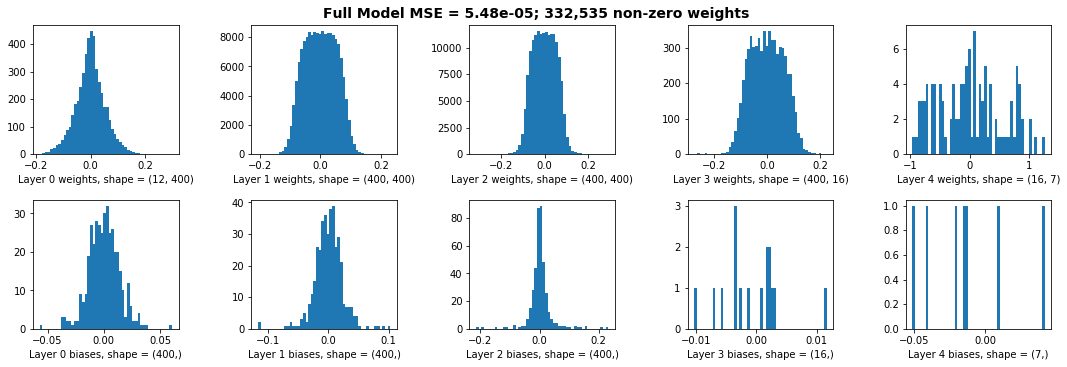

In [76]:
# make histogram of weights
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15 ,5)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

my_suptitle = fig.suptitle('Full Model MSE = 5.48e-05; 332,535 non-zero weights', fontsize=14, fontweight='bold', y = 1.01)

axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 50)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 50)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))
plt.tight_layout()
plt.savefig(os.path.join(figDir, "HistogramsOfWeights.png"), dpi = 200,bbox_inches='tight', bbox_extra_artists=[my_suptitle])
plt.show()

In [79]:
# change weights
for ii in np.arange(2, 7):
    wts[ii][abs(wts[ii]) < 0.01] = 0

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

293530

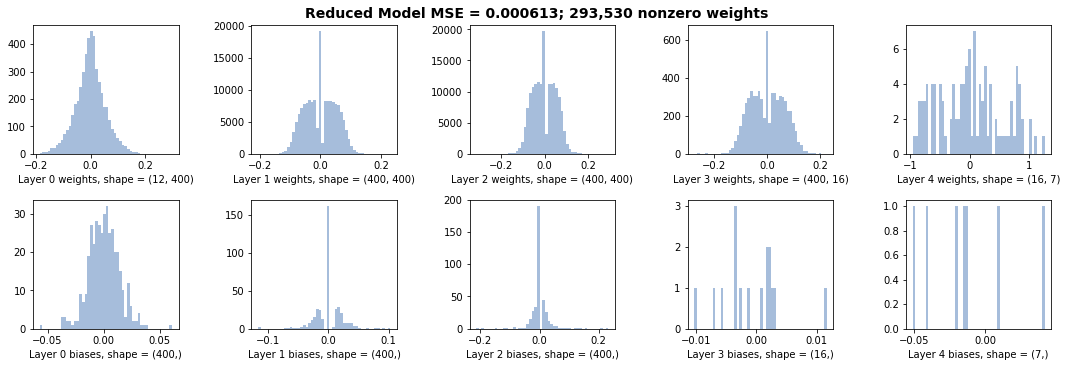

In [78]:
# make histogram of weights
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15 ,5)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

my_suptitle = fig.suptitle('Reduced Model MSE = 0.000613; 293,530 nonzero weights', fontsize=14, fontweight='bold', y = 1.01)

axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), facecolor = '#a6bddb', bins = 50)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], facecolor = '#a6bddb', bins = 50)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))
plt.tight_layout()
plt.savefig(os.path.join(figDir, "HistogramsOfWeights_updatedWeights_01.png"), dpi = 200,bbox_inches='tight', bbox_extra_artists=[my_suptitle])
plt.show()

In [80]:
# set wts
model.set_weights(wts)

In [178]:
# evaluate with new weights
model.evaluate(Xtest_scaled, Ytest_scaled)

2000000/2000000 [==============================] - 58s 29us/step


[0.10874714509284496, 0.10874714509284496]

In [81]:
nnpreds = model.predict(Xtest_scaled[ :])
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

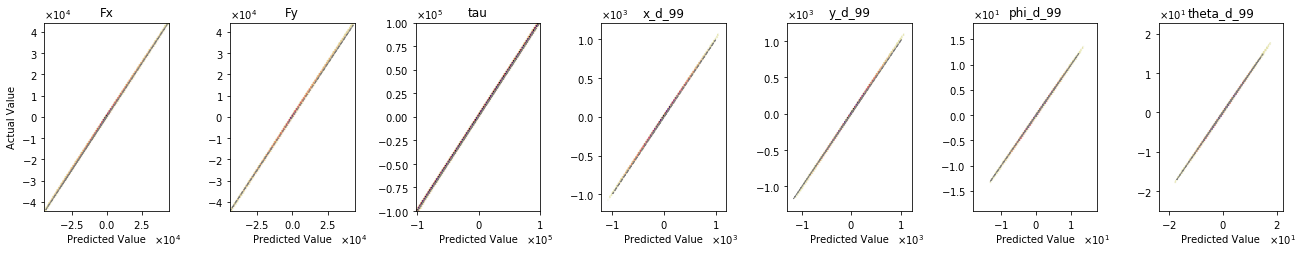

In [82]:
# plot what that looks like
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
        t = axs[ii].xaxis.get_offset_text()
        t.set_x(1.1)
        t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

fig.savefig(os.path.join(figDir, "NNPreds_0Weights_01.png"), dpi = 500, bbox_inches='tight')


In [63]:
# change weights
for ii in np.arange(2, 7):
    wts[ii][abs(wts[ii]) < 0.05] = 0

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

140274

In [109]:
# set wts
model.set_weights(wts)

In [111]:
# evaluate with new weights
model.evaluate(Xtest_scaled, Ytest_scaled)

2000000/2000000 [==============================] - 59s 30us/step


[0.12957763905882835, 0.12957763905882835]

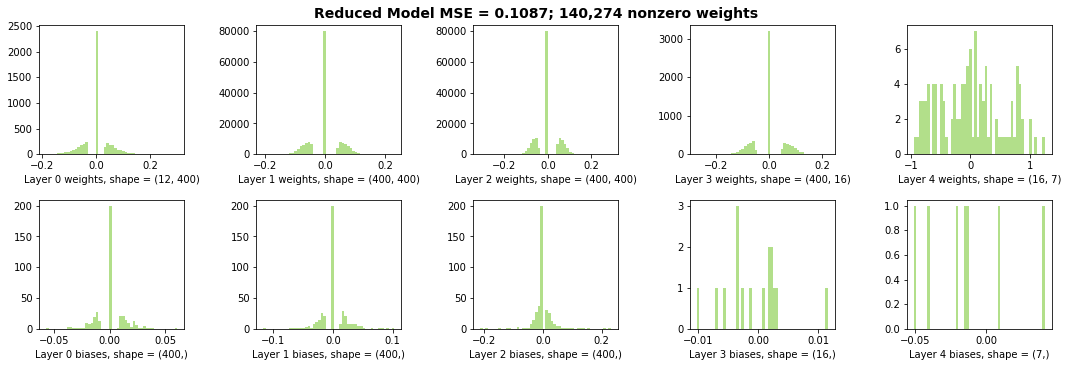

In [110]:
# make histogram of weights
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15 ,5)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

my_suptitle = fig.suptitle('Reduced Model MSE = 0.1087; 140,274 nonzero weights', fontsize=14, fontweight='bold', y = 1.01)

axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), facecolor = '#b2df8a', bins = 50)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], facecolor = '#b2df8a', bins = 50)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))
plt.tight_layout()
plt.savefig(os.path.join(figDir, "HistogramsOfWeights_updatedWeights_05.png"), dpi = 200,bbox_inches='tight', bbox_extra_artists=[my_suptitle])
plt.show()

In [115]:
# trim distribution of weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

266055

In [116]:
# set wts
model.set_weights(wts)

In [117]:
# evaluate with new weights
model.evaluate(Xtest_scaled, Ytest_scaled)

2000000/2000000 [==============================] - 60s 30us/step


[0.0037076423169076444, 0.0037076423169076444]

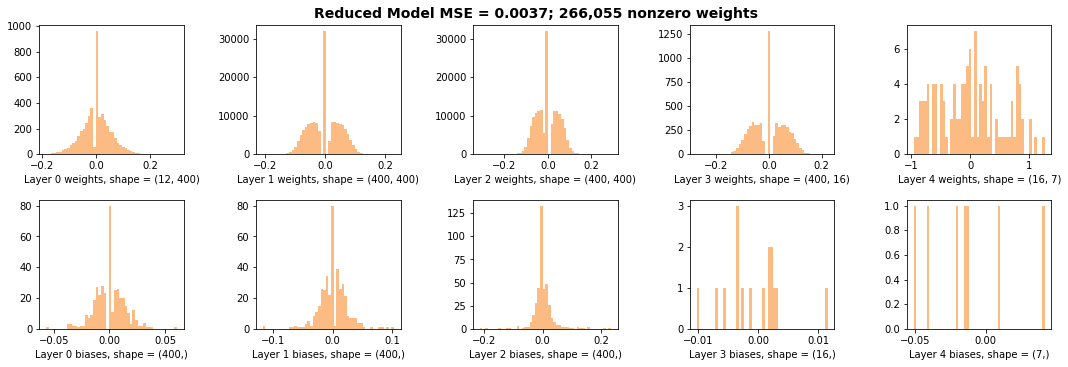

In [119]:
# make histogram of weights
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15 ,5)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)

my_suptitle = fig.suptitle('Reduced Model MSE = 0.0037; 266,055 nonzero weights', fontsize=14, fontweight='bold', y = 1.01)

axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):
    
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), facecolor = '#fdbb84', bins = 50)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], facecolor = '#fdbb84', bins = 50)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))
plt.tight_layout()
plt.savefig(os.path.join(figDir, "HistogramsOfWeights_updatedWeights_IQR.png"), dpi = 200,bbox_inches='tight', bbox_extra_artists=[my_suptitle])
plt.show()

In [120]:
nnpreds = model.predict(Xtest_scaled[ :])

In [121]:
# save model
# model.save(os.path.join(savedModels, 'my_model.h5'))
# aa = r'explorer /select,"'
# subprocess.Popen(str(aa + savedModels + '\"'))

In [122]:
# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

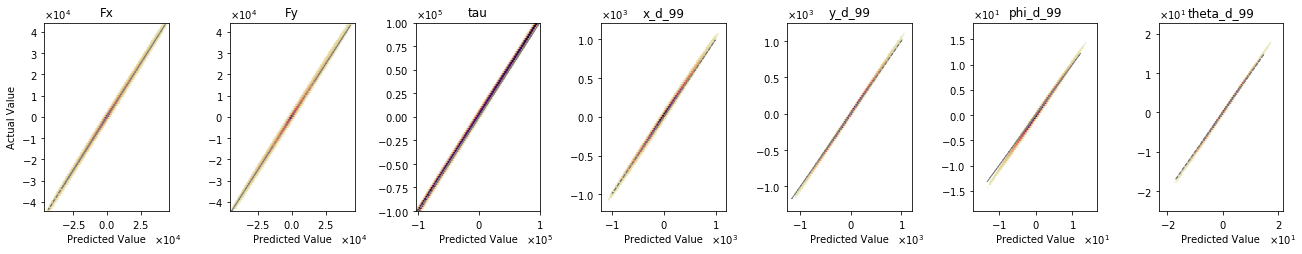

In [123]:
plt.close("all")
fig, axs = plt.subplots(1,7, figsize=np.array((20, 4)) / 1.1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()

nms = Y.columns
nms2 = [nms[ii].replace("dot", "d") for ii in range(len(nms))]
nms2

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].set_xlabel("Predicted Value")
        axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='both', scilimits=(3,4))
        t = axs[ii].xaxis.get_offset_text()
        t.set_x(1.1)
        t.set_y(0.5)
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass
plt.tight_layout()

fig.savefig(os.path.join(figDir, "NNPreds_IQR.png"), dpi = 500, bbox_inches='tight')
# fig.savefig(os.path.join(figDir, "NNPreds_newData_control_bigbatch_FxFy_hexbin_loadedModel.svg"),bbox_inches='tight')

# residual plots

YES


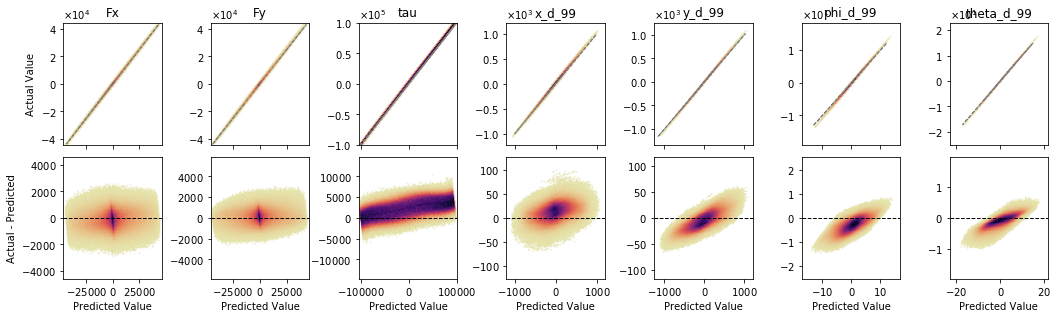

In [124]:
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = 0.3, wspace=0.3)
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
#fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel()


# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
#cmaplist[0:2] = np.repeat((0.0,0.0,0.0,0.0), 2).reshape(-1,4)
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
#cmaplist[:,0:3] = np.transpose(np.vstack([np.linspace(1, 0, 256), np.linspace(1, 0, 256), np.linspace(1, 0, 256)]))
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    # read in image
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
#         axs[ii].set_xlabel("Predicted Value")
#         axs[ii].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            print("YES")
            axs[jj].set_ylabel("Actual - Predicted")
        #axs[jj].set_title(nms2[ii])
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
#plt.tight_layout()
fig.savefig(os.path.join(figDir, "NNPreds_resids_combined_IQR.png"), dpi = 500, bbox_inches='tight')


In [36]:
for ii in range(len(nms)):
    #np.sqrt(mean_squared_error(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]))
    print(r2_score(Ytest.iloc[0:1000,ii], nnpreds_unscaled[:,ii]), nms[ii])

0.9999506847353872 Fx
0.9999627147331593 Fy
0.9999438044472624 tau
0.9999599609986949 x_dot_99
0.9999467703504513 y_dot_99
0.9999202305164062 phi_dot_99
0.9999309651201447 theta_dot_99


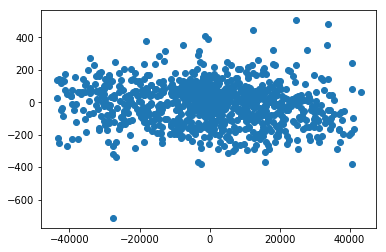

In [28]:
plt.scatter( nnpreds_unscaled[:,ii],Ytest.iloc[0:1000,ii]-  nnpreds_unscaled[:,ii])